In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'DKK=X'
numbers_in_currency = 'DKK'
share_name = 'BAVA.CO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,165,-85,80,-55,115,106,236,673,0,...,87,0,9,248,68,330,-90,-25,26.4,2014-08-24
1,2014-09-30,225,-99,126,-18,146,184,233,671,0,...,70,0,2,292,75,382,-40,-24,26.4,2014-11-14
2,2014-12-31,541,-167,374,98,398,187,122,1319,0,...,59,0,2,583,33,635,548,-23,26.4,2015-03-04
3,2015-03-31,235,-92,143,45,1019,76,142,1924,0,...,67,0,2,1144,33,1195,599,-9,28.6,2015-05-10
4,2015-06-30,389,-110,279,61,505,190,141,1703,0,...,47,0,2,821,32,872,-293,-11,28.6,2015-08-24


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-03-31,2023-05-10,77.87,1252,-428,824,376,1272,751,1203,...,6084,13181,445,0,26,1789,1580,4060,-215,-243
36,2023-06-30,2023-08-24,78.10,1987,-684,1303,538,832,1314,1508,...,7904,14993,764,0,46,2926,1432,5307,442,-317
37,2023-09-30,2023-11-14,78.10,1376,-514,862,-341,1032,1166,1740,...,6535,13399,794,0,40,2887,1041,4063,306,-173
38,2023-12-31,2024-03-03,78.10,2447,-833,1614,901,1477,1781,1644,...,6482,14353,954,0,47,2788,15,4013,585,-244
39,2024-03-31,2024-05-06,78.10,831,-566,265,-114,860,663,1782,...,6404,13621,480,0,47,2935,15,3446,399,9


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-03-31,2023-05-10,77.87,1252,-428,824,376,1272,751,1203,...,13181,445,0,26,1789,1580,4060,-215,-243,6.936642
36,2023-06-30,2023-08-24,78.10,1987,-684,1303,538,832,1314,1508,...,14993,764,0,46,2926,1432,5307,442,-317,6.841692
37,2023-09-30,2023-11-14,78.10,1376,-514,862,-341,1032,1166,1740,...,13399,794,0,40,2887,1041,4063,306,-173,6.848087
38,2023-12-31,2024-03-03,78.10,2447,-833,1614,901,1477,1781,1644,...,14353,954,0,47,2788,15,4013,585,-244,6.933528
39,2024-03-31,2024-05-06,78.10,831,-566,265,-114,860,663,1782,...,13621,480,0,47,2935,15,3446,399,9,6.863684


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-03-31,2023-05-10,77.87,1252,-428,824,376,1272,751,1203,...,13181,445,0,26,1789,1580,4060,-215,-243,6.936642
36,2023-06-30,2023-08-24,78.10,1987,-684,1303,538,832,1314,1508,...,14993,764,0,46,2926,1432,5307,442,-317,6.841692
37,2023-09-30,2023-11-14,78.10,1376,-514,862,-341,1032,1166,1740,...,13399,794,0,40,2887,1041,4063,306,-173,6.848087
38,2023-12-31,2024-03-03,78.10,2447,-833,1614,901,1477,1781,1644,...,14353,954,0,47,2788,15,4013,585,-244,6.933528
39,2024-03-31,2024-05-06,78.10,831,-566,265,-114,860,663,1782,...,13621,480,0,47,2935,15,3446,399,9,6.863684


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-08-25,88.599396,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.737052,0.262948,0.0,0.0,0.0,0.0,0.484848,-0.333333,0.0,0.0
1,2014-09-01,92.950256,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.737052,0.262948,0.0,0.0,0.0,0.0,0.484848,-0.333333,0.0,0.0
2,2014-09-08,93.345787,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.737052,0.262948,0.0,0.0,0.0,0.0,0.484848,-0.333333,0.0,0.0
3,2014-09-15,89.390457,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.737052,0.262948,0.0,0.0,0.0,0.0,0.484848,-0.333333,0.0,0.0
4,2014-09-22,88.599396,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.737052,0.262948,0.0,0.0,0.0,0.0,0.484848,-0.333333,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-08-25,88.599396,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.0,0.484848,-0.333333,0.0,0.0,inf,2.528675,inf,inf,inf
1,2014-09-01,92.950256,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.0,0.484848,-0.333333,0.0,0.0,inf,2.652851,inf,inf,inf
2,2014-09-08,93.345787,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.0,0.484848,-0.333333,0.0,0.0,inf,2.664139,inf,inf,inf
3,2014-09-15,89.390457,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.0,0.484848,-0.333333,0.0,0.0,inf,2.551252,inf,inf,inf
4,2014-09-22,88.599396,2014-06-30,165.0,0.0,35.037879,26.4,0.0,0.0,115.0,...,0.0,0.484848,-0.333333,0.0,0.0,inf,2.528675,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

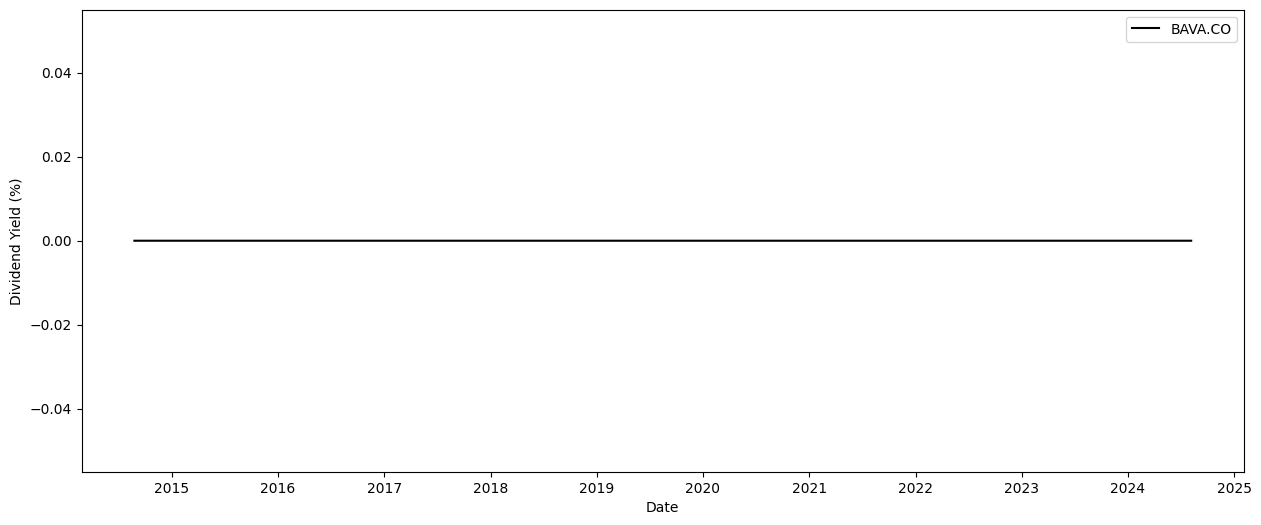

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.116366
share_price      1.000000
Name: share_price, dtype: float64


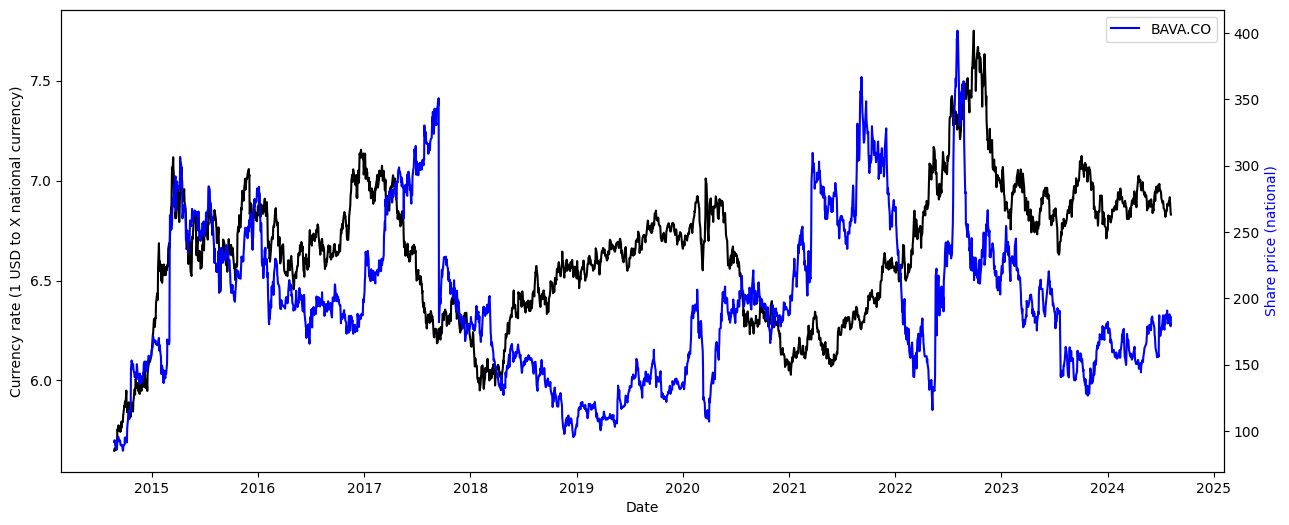

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

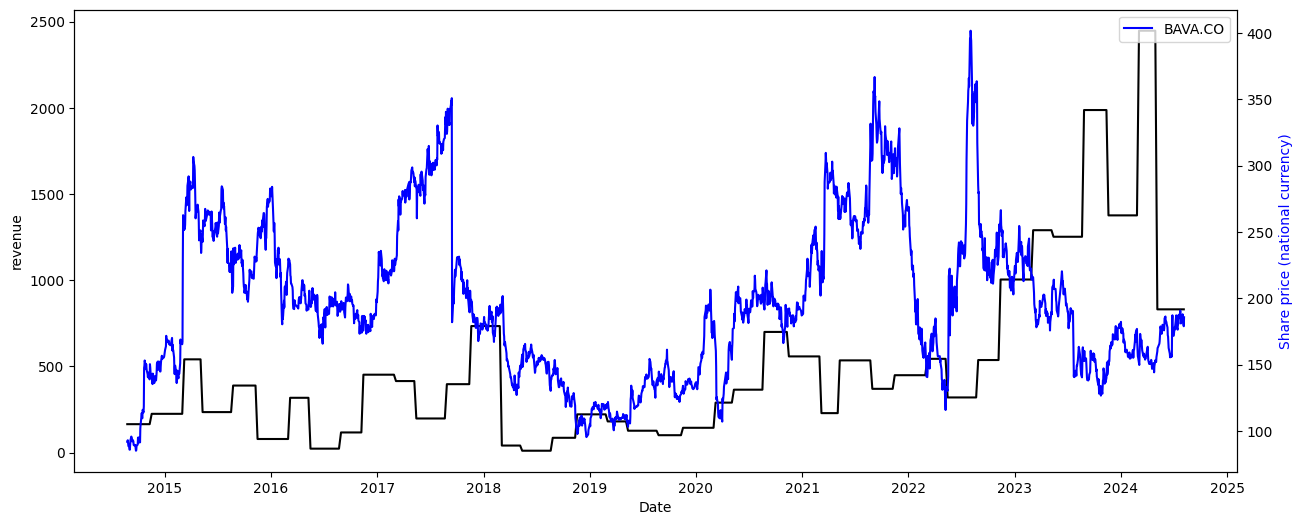

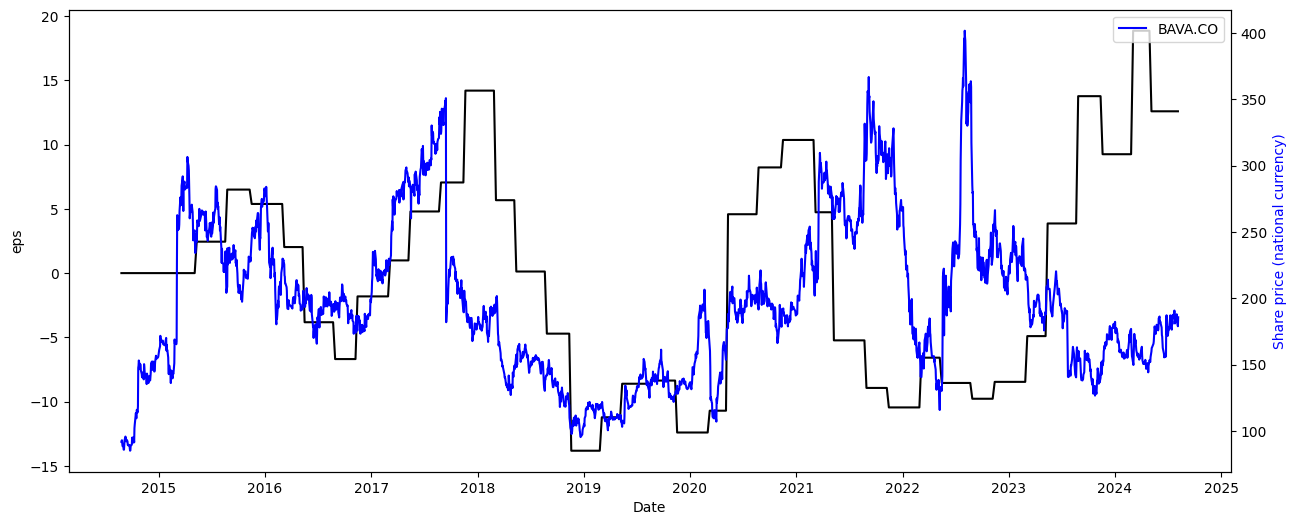

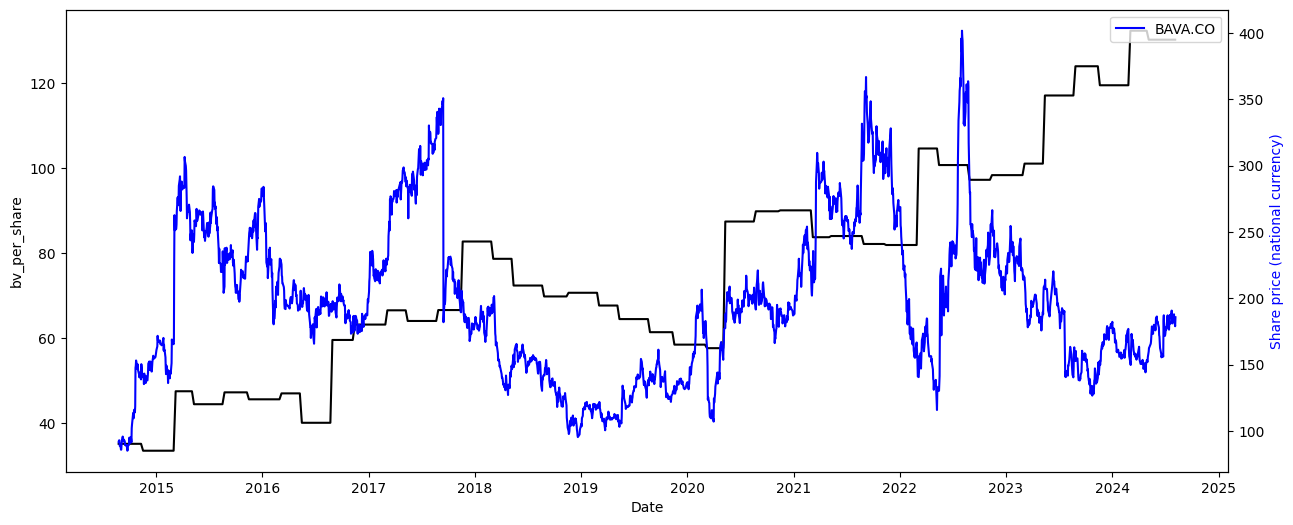

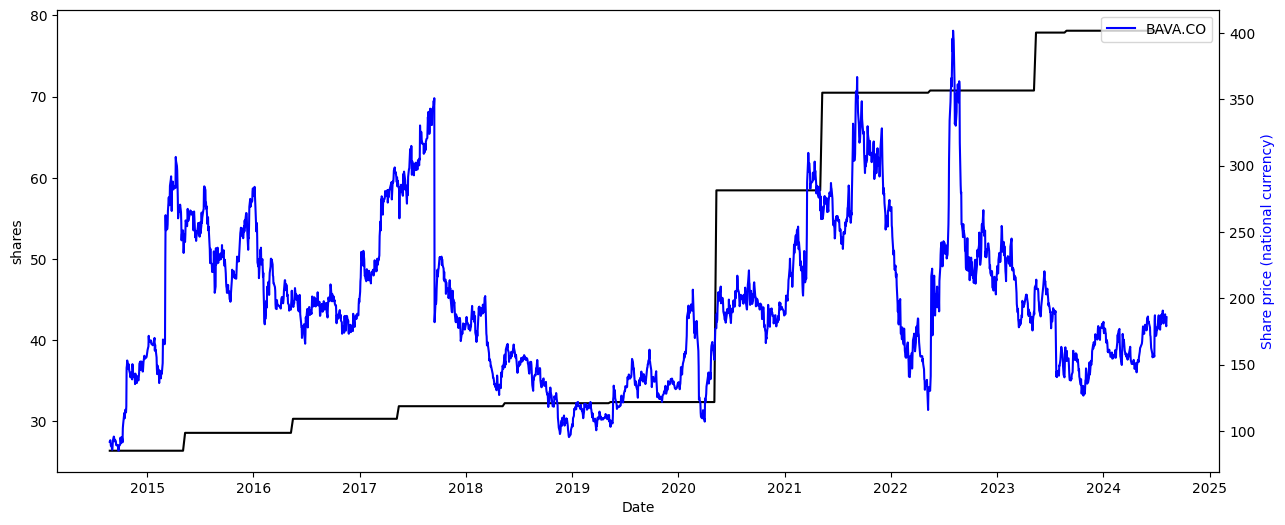

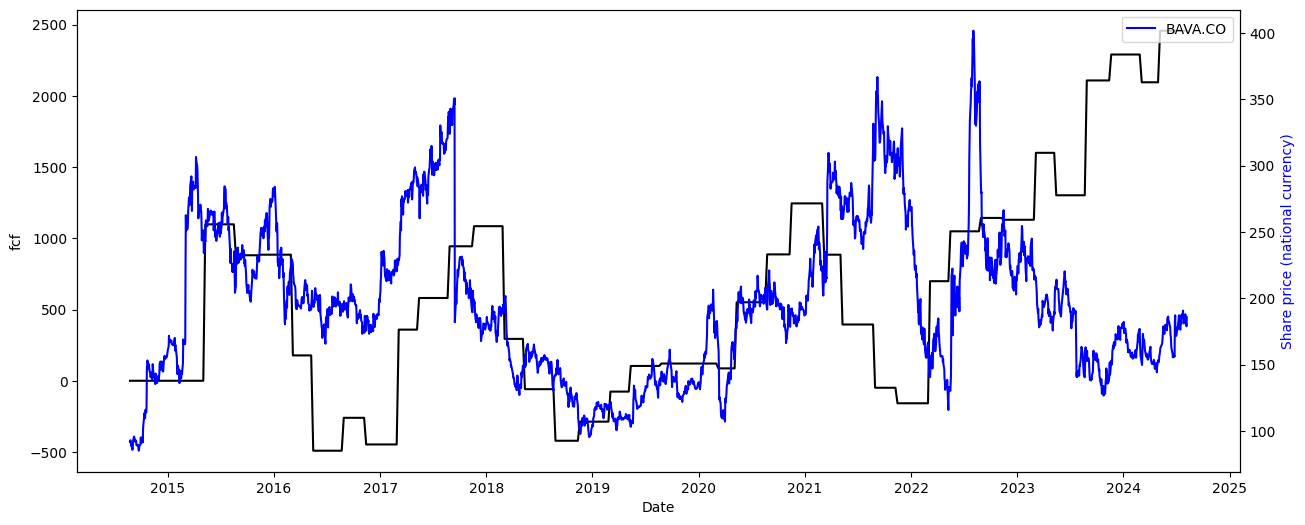

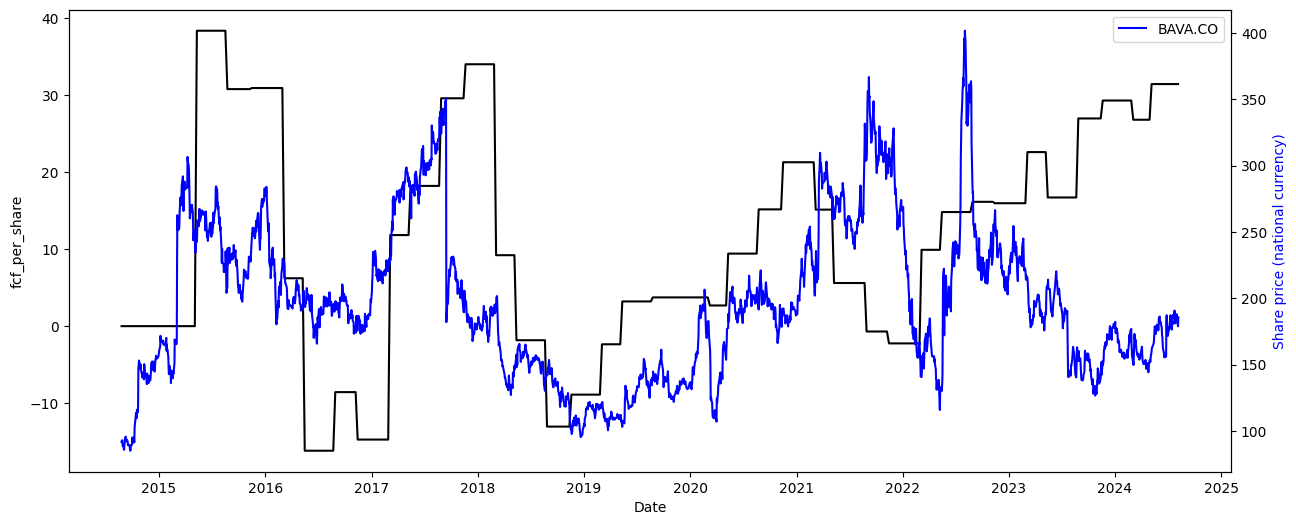

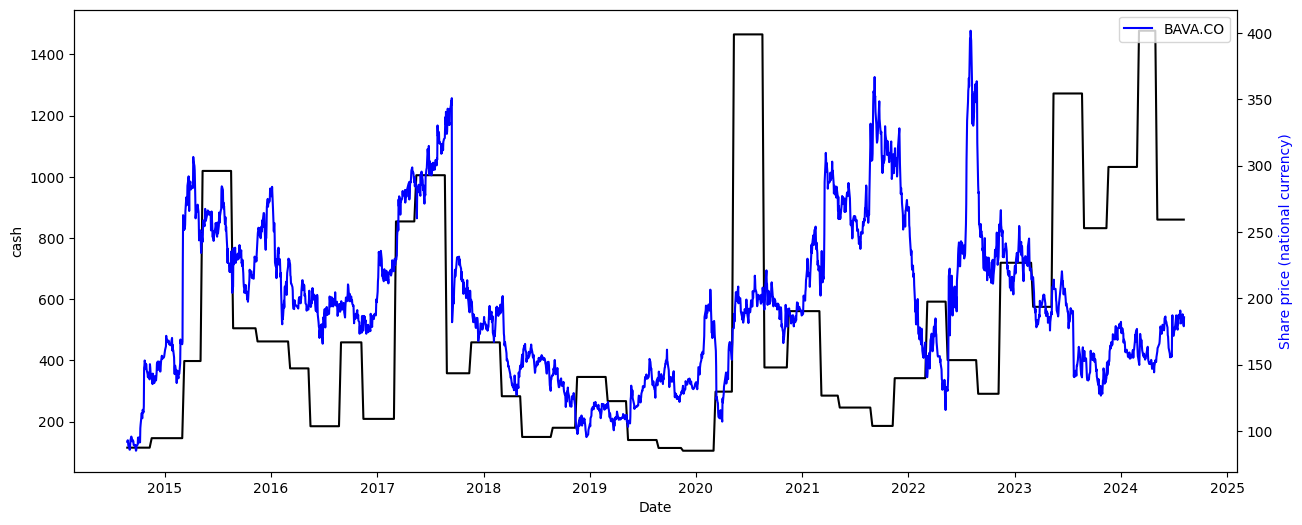

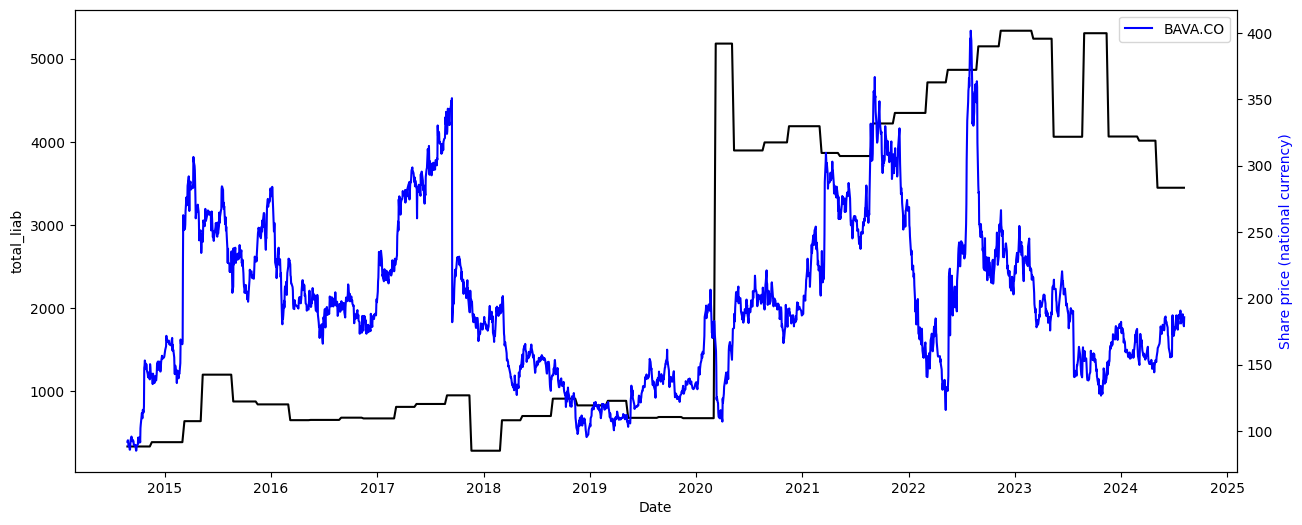

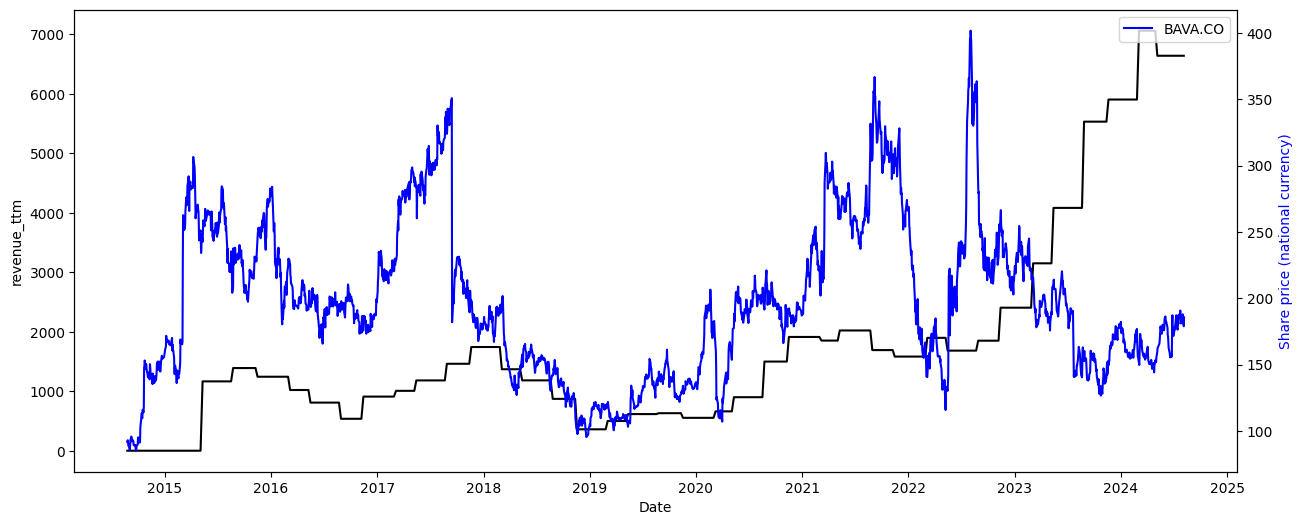

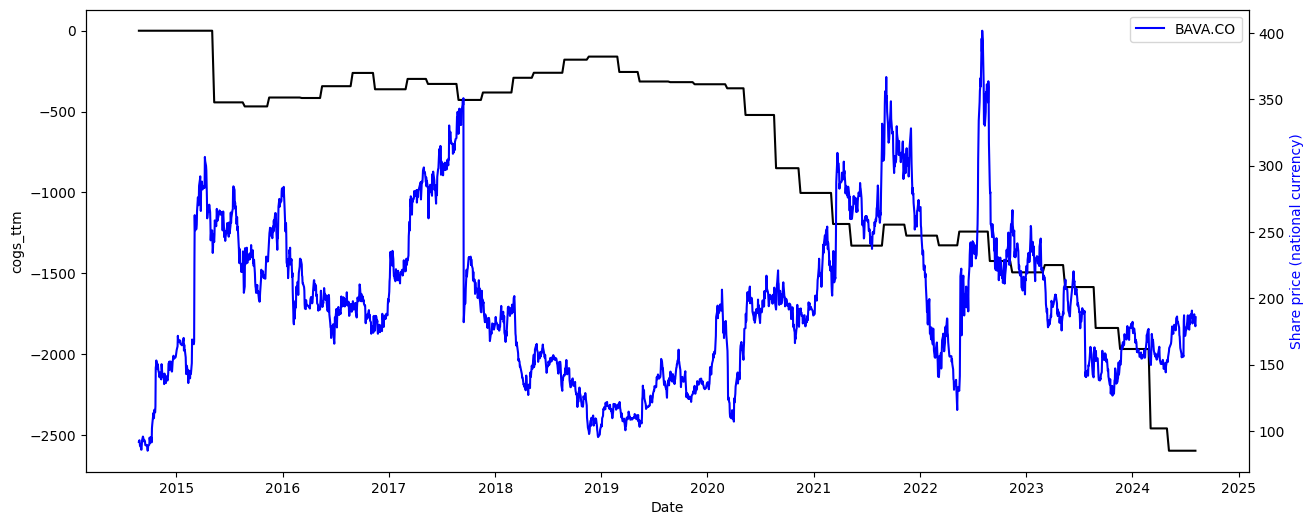

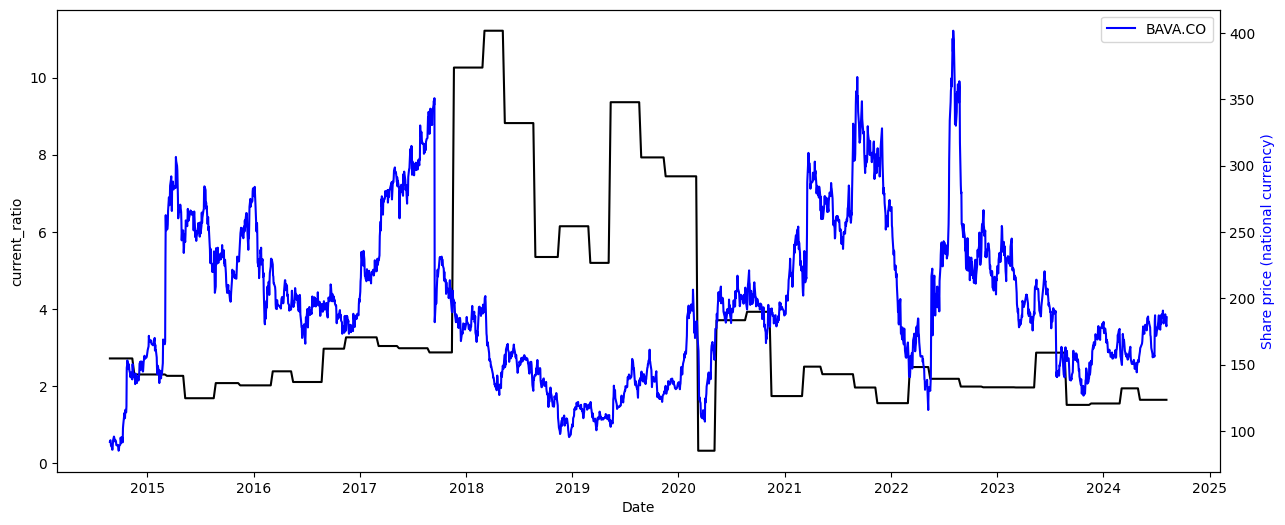

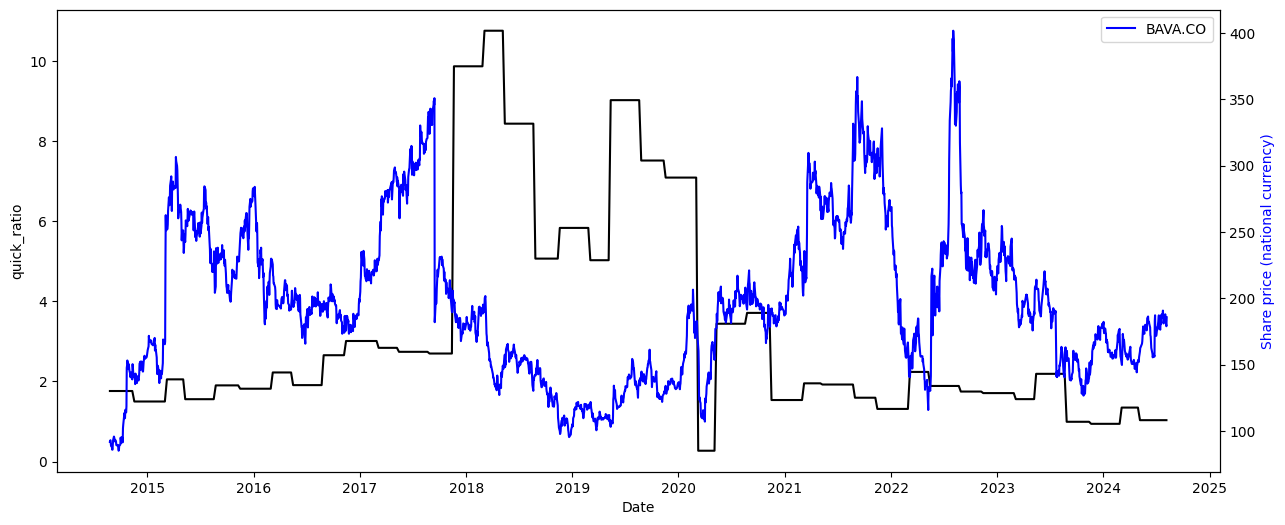

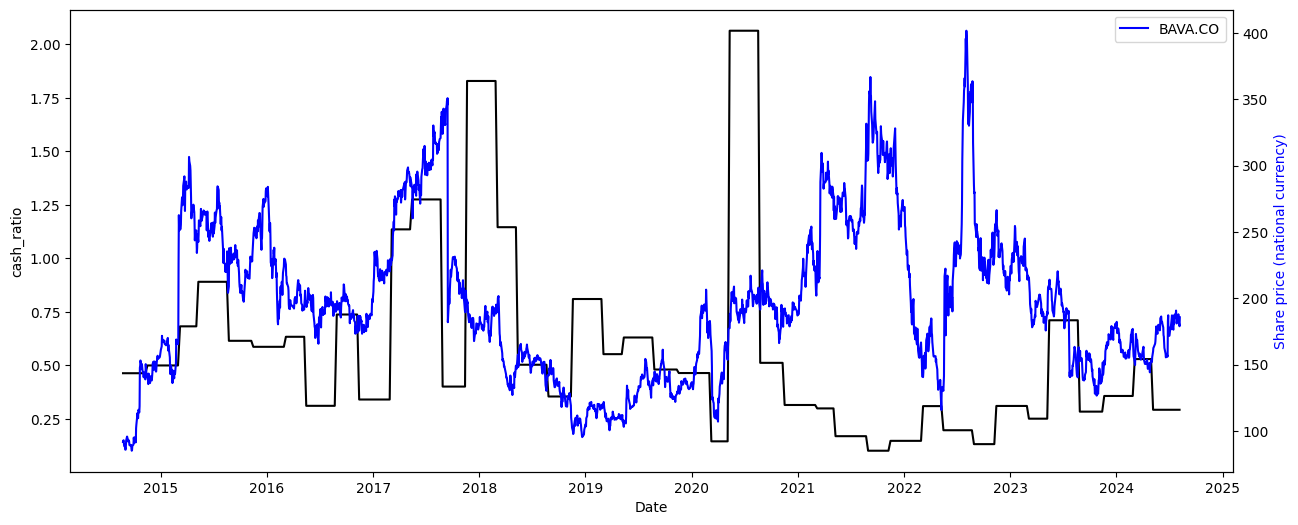

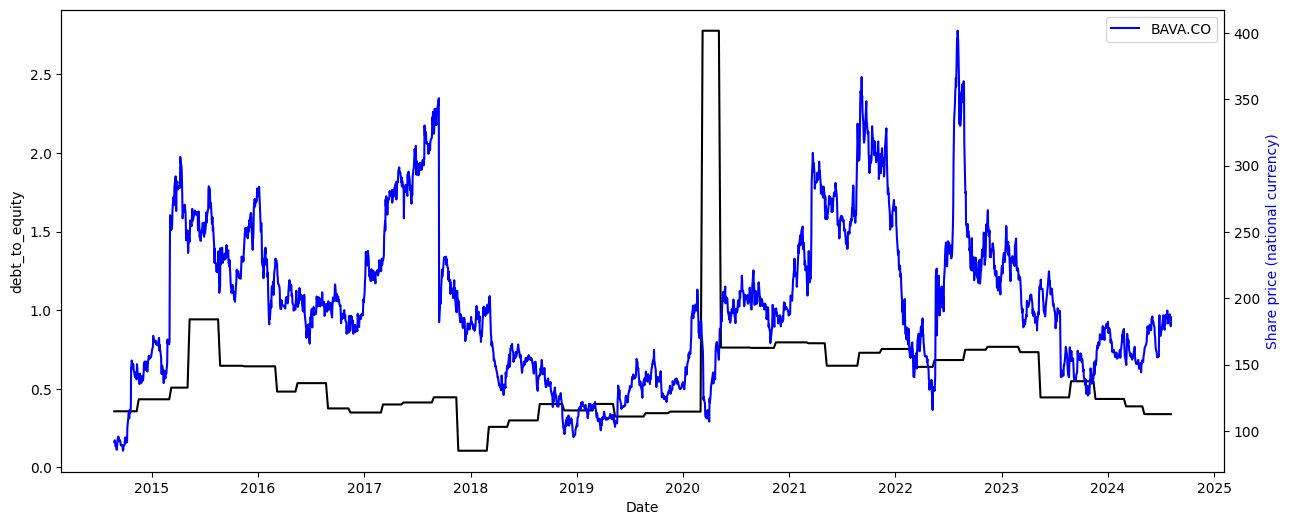

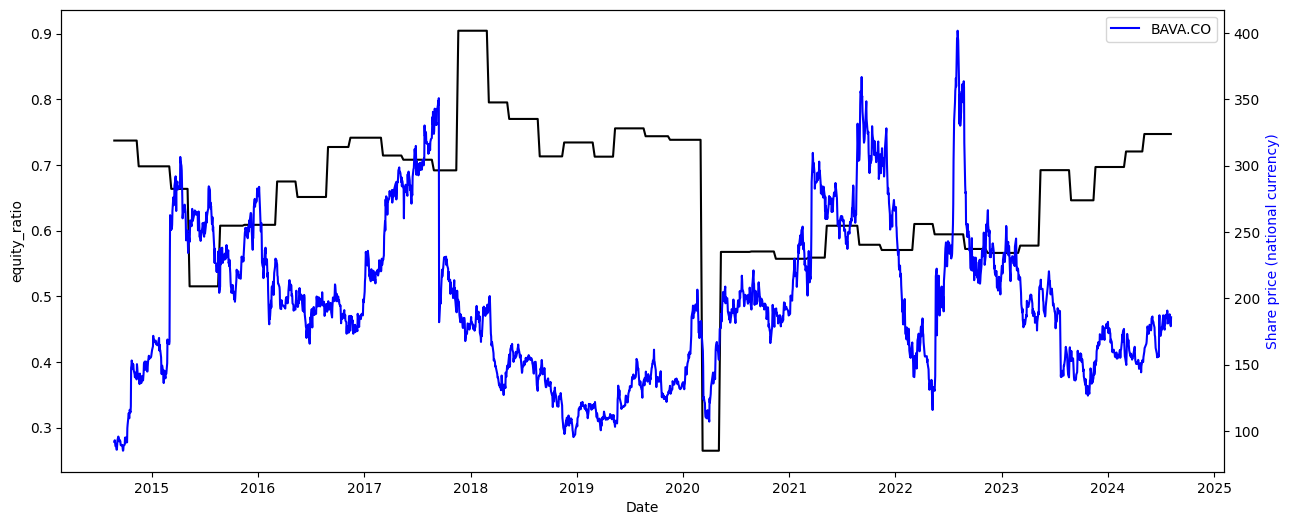

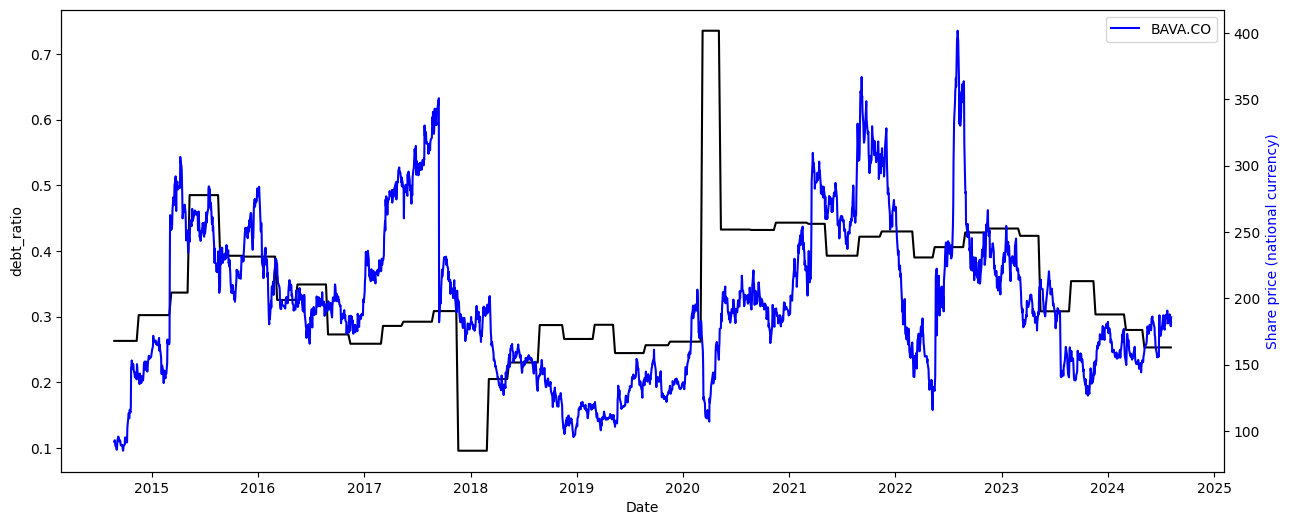

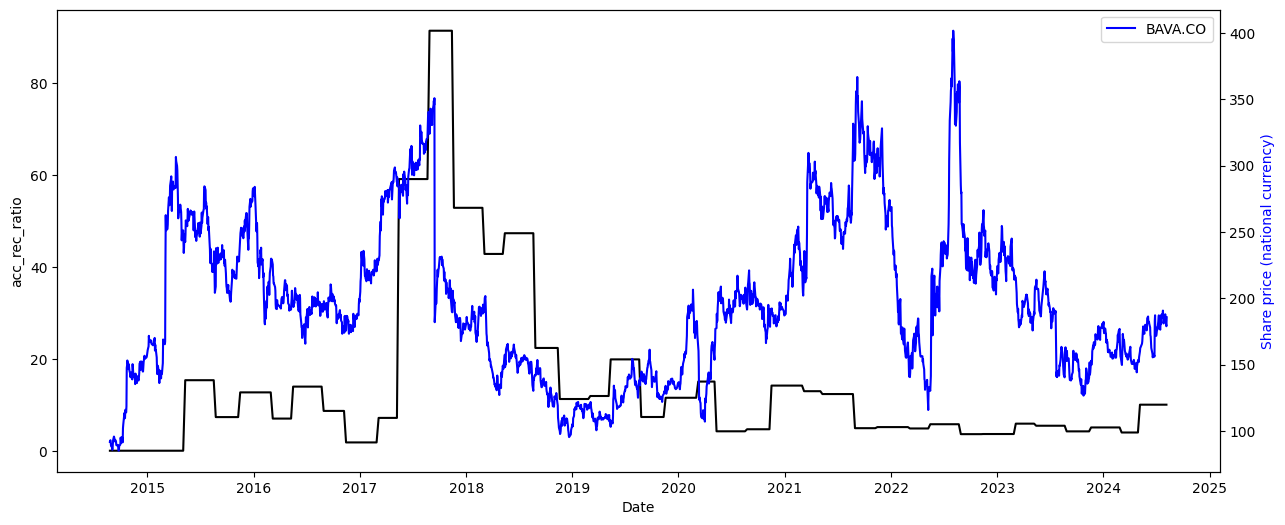

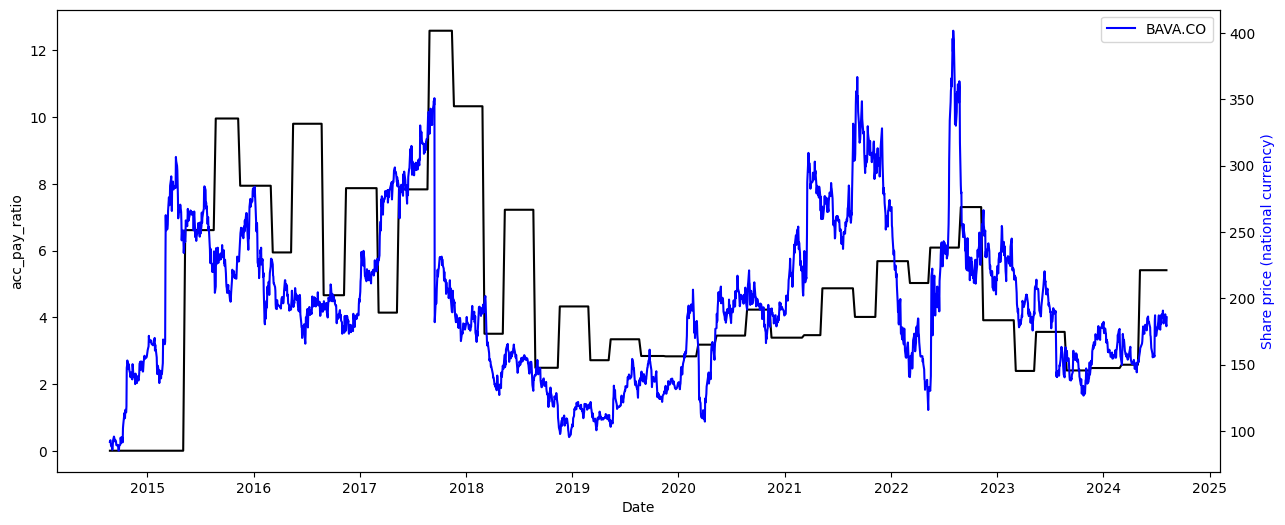

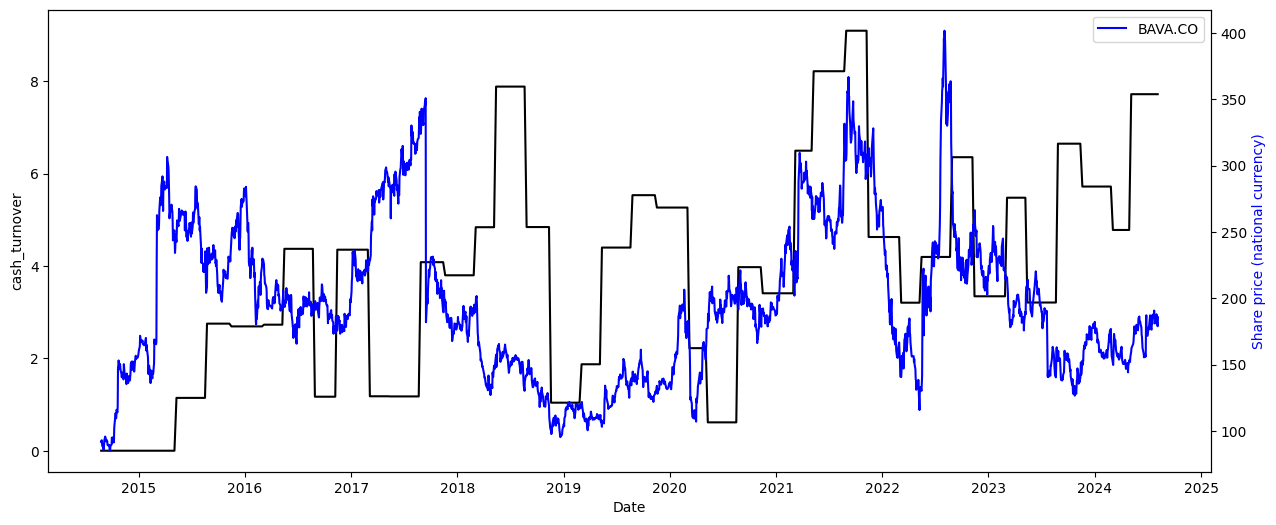

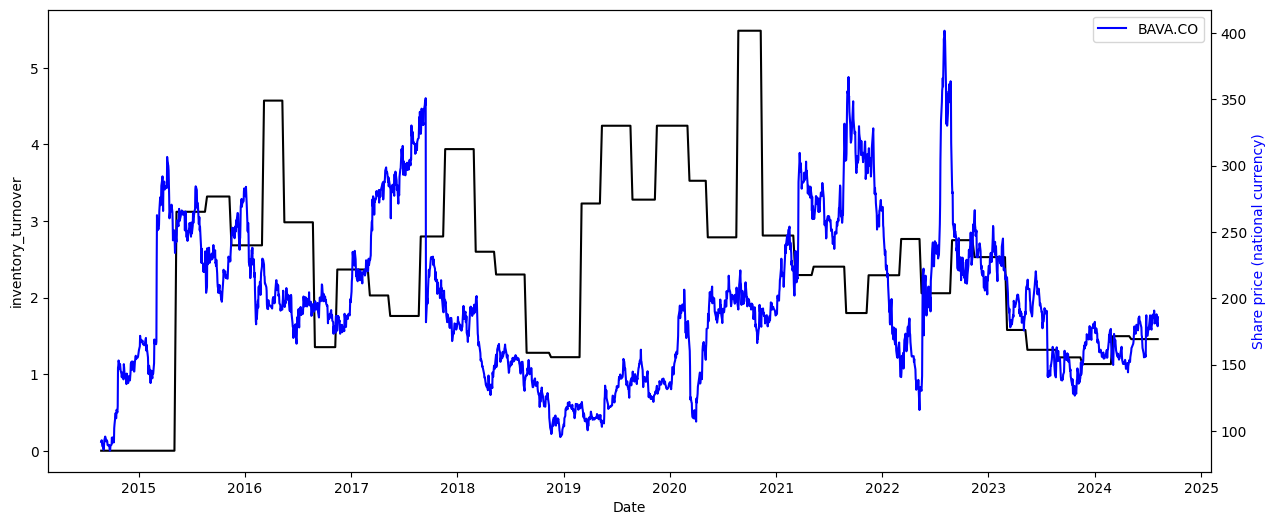

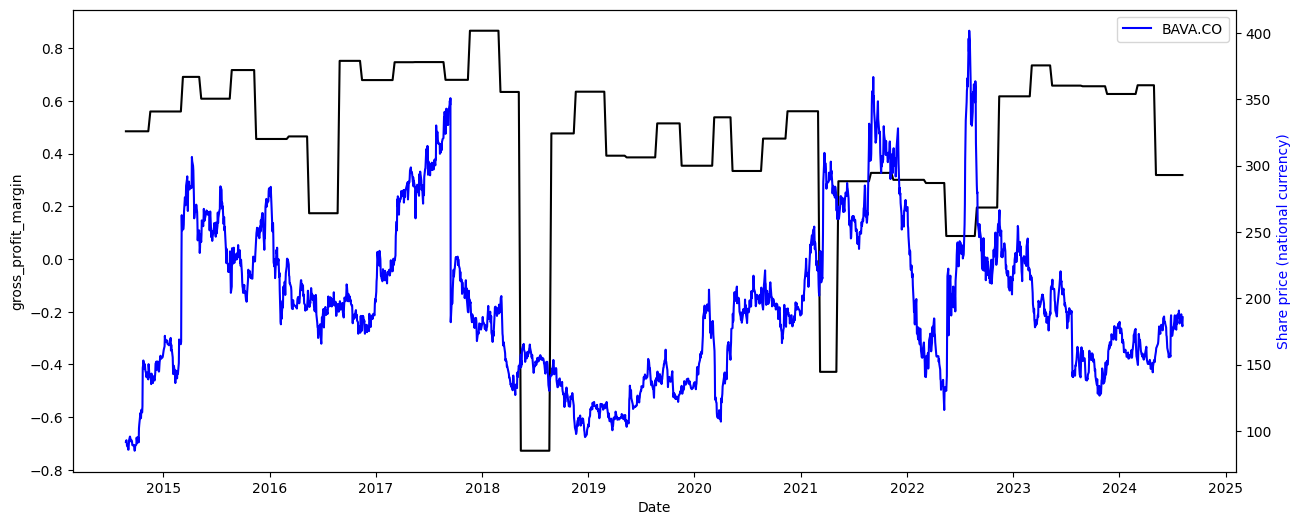

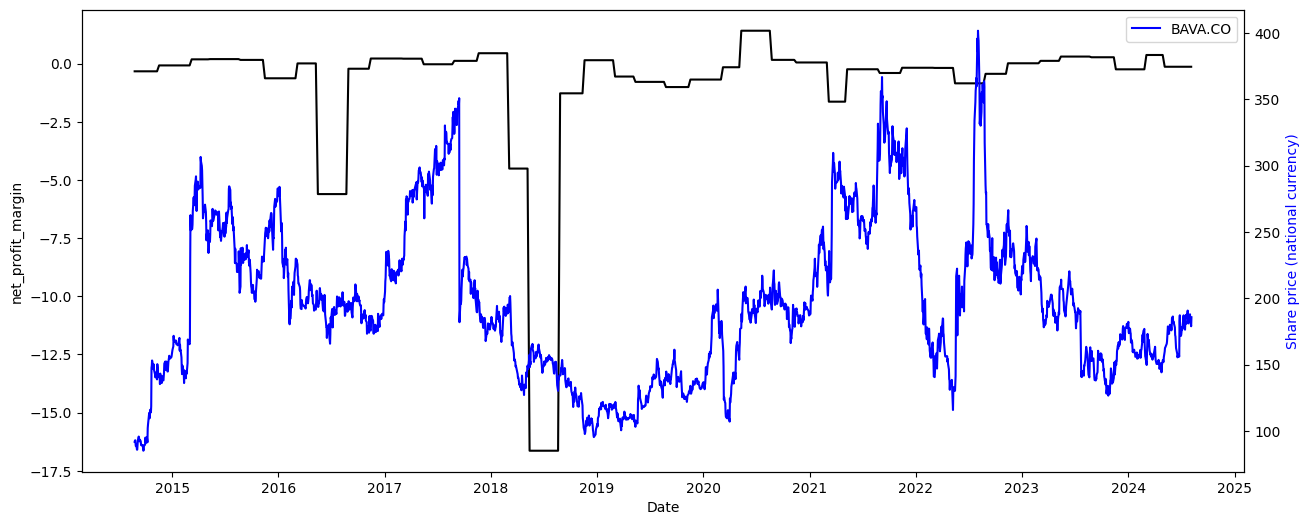

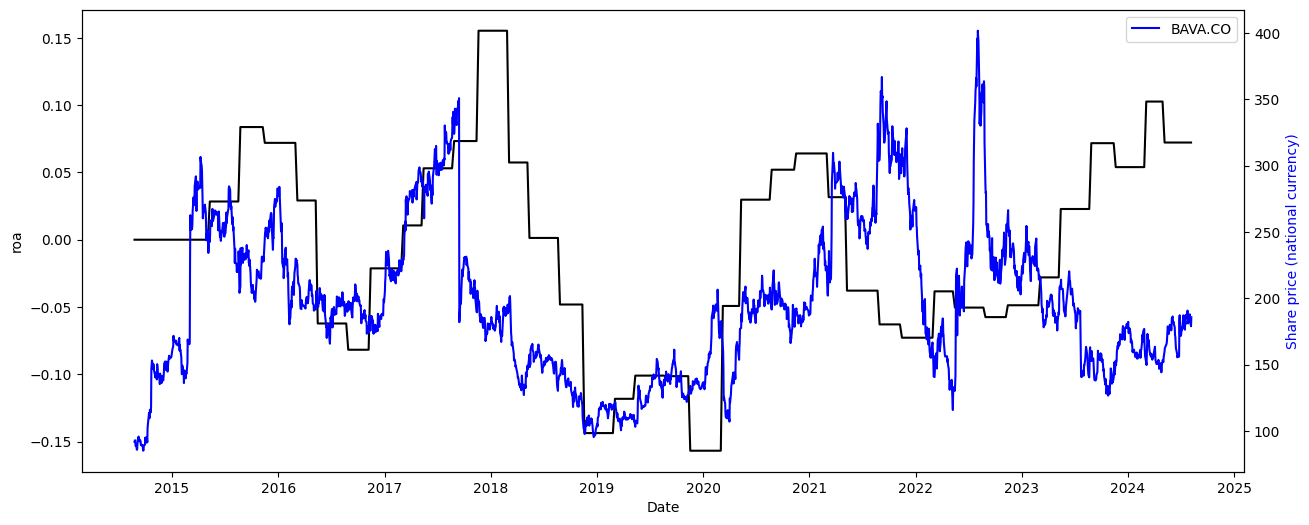

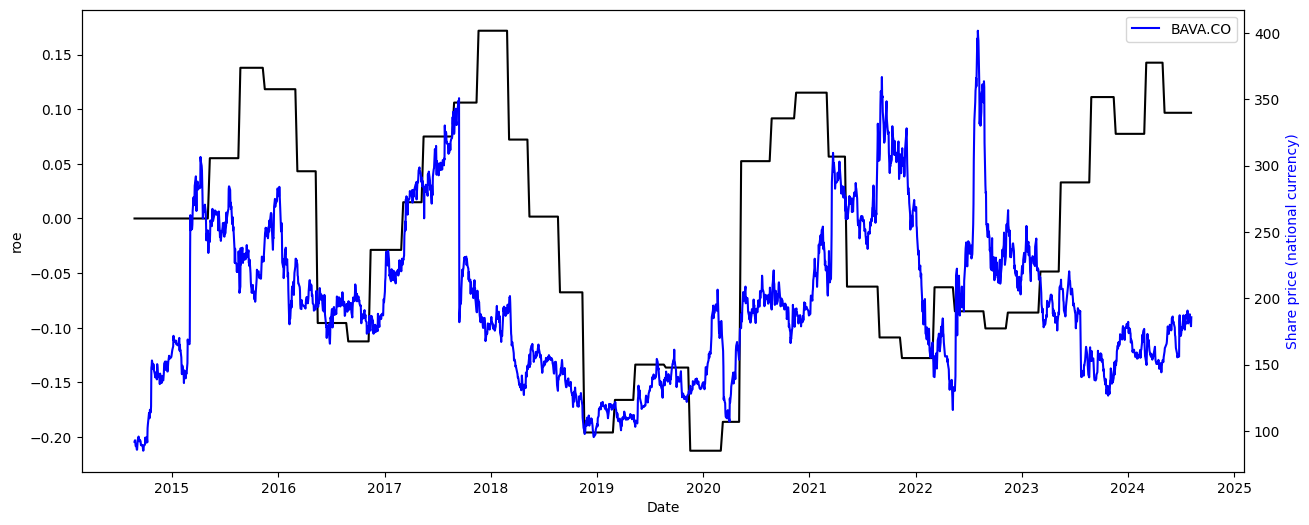

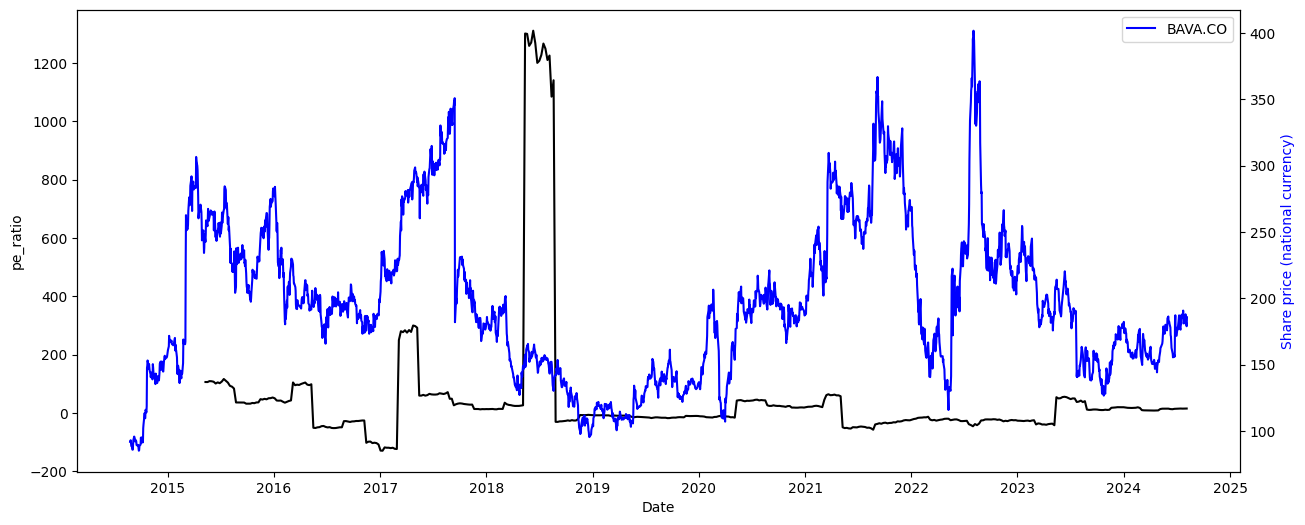

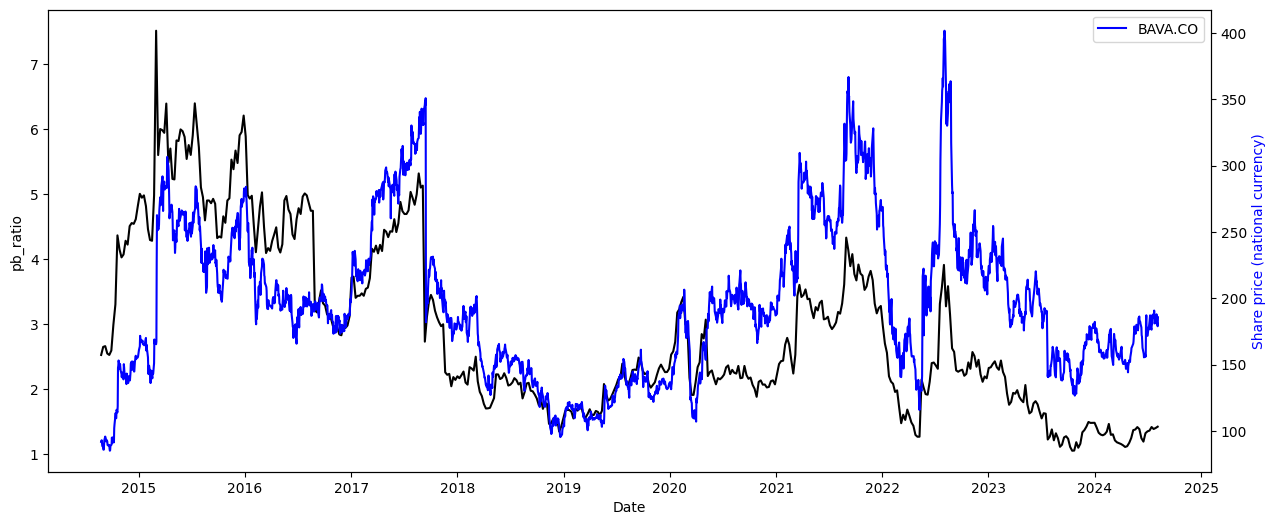

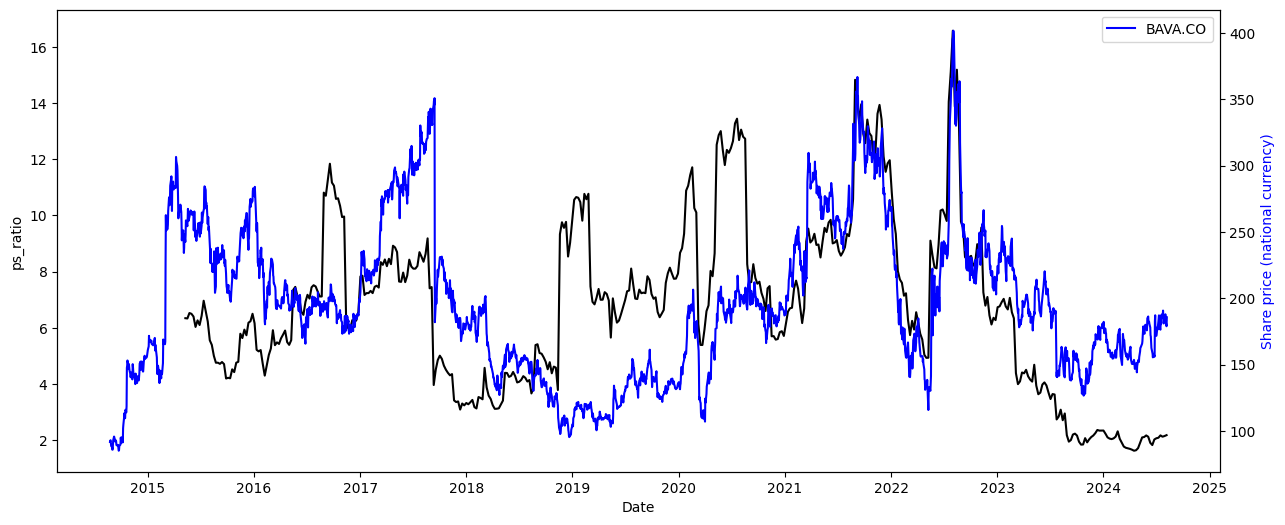

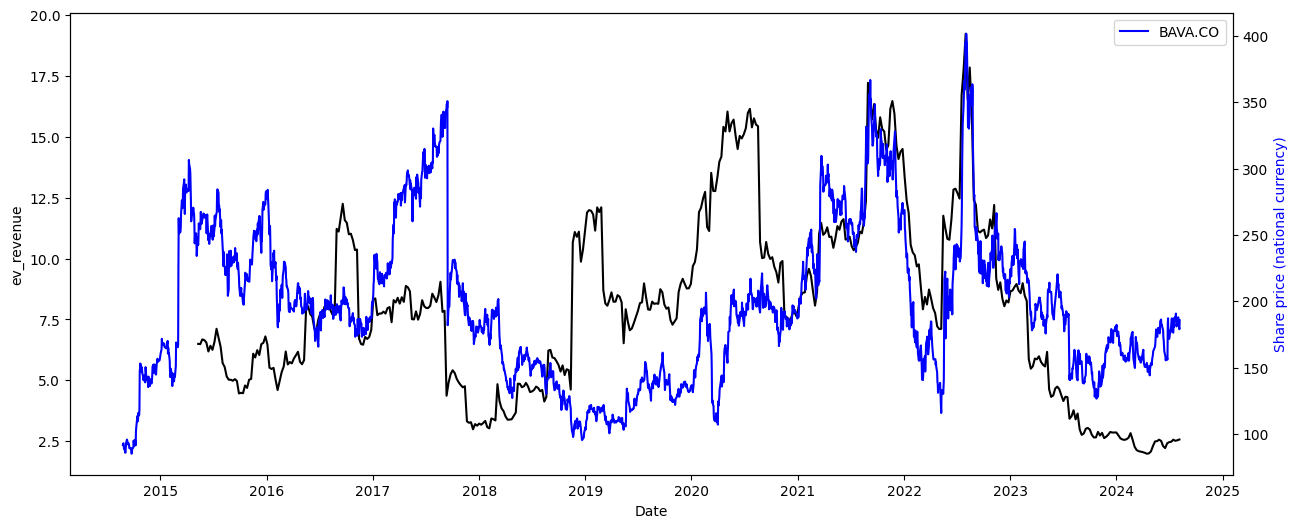

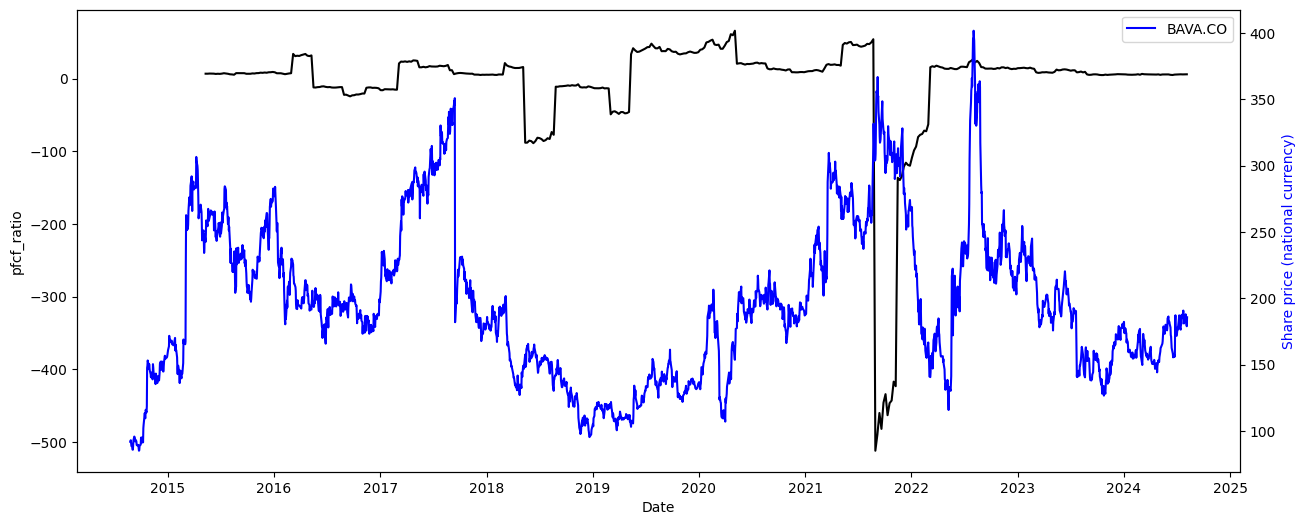

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

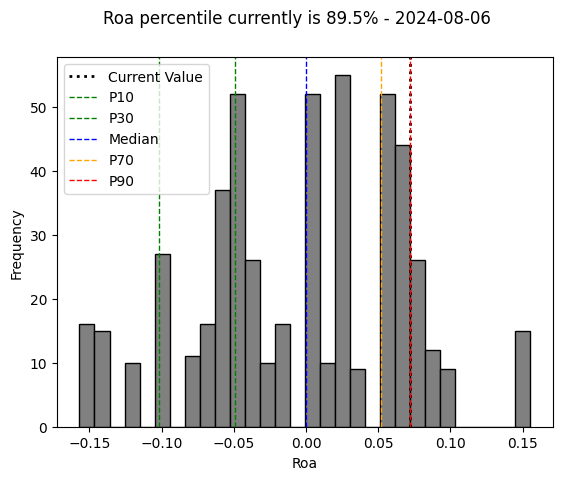

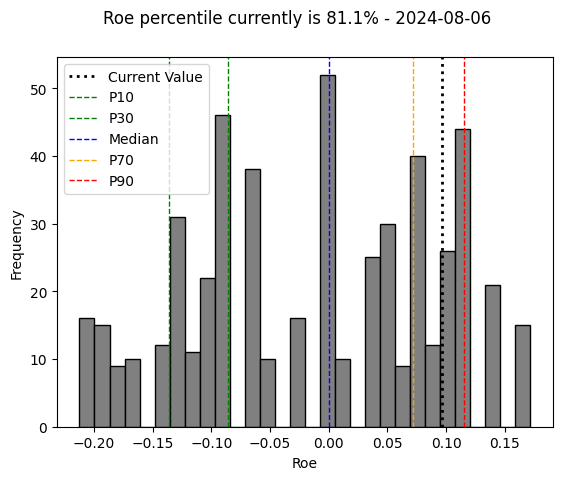

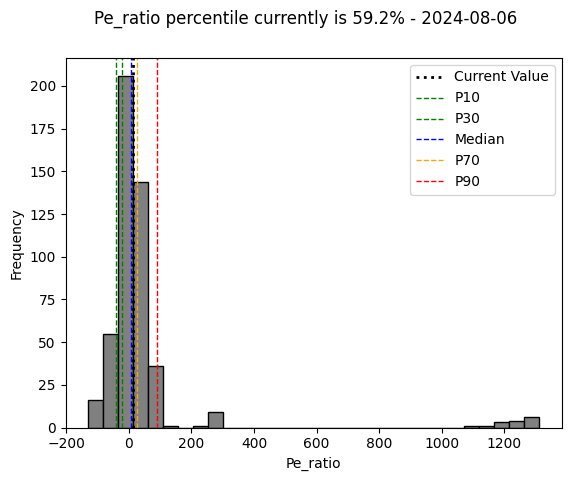

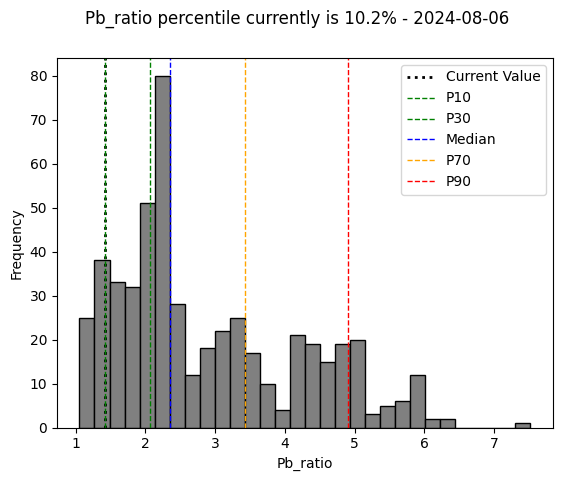

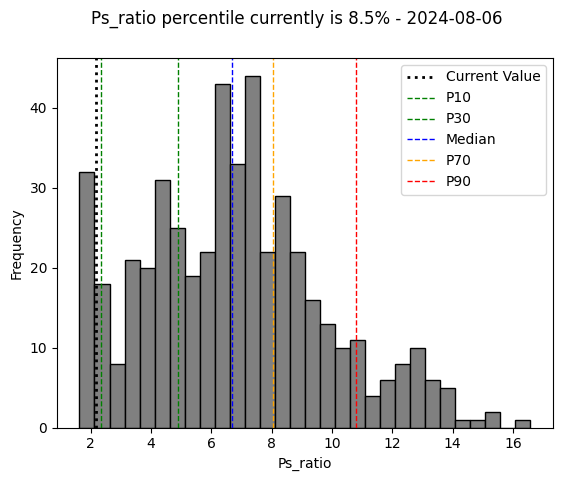

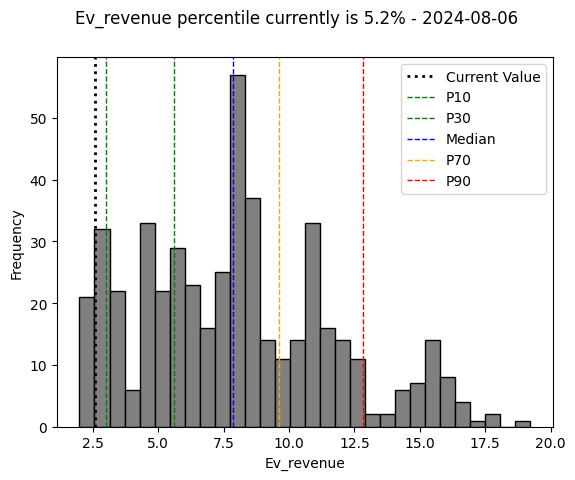

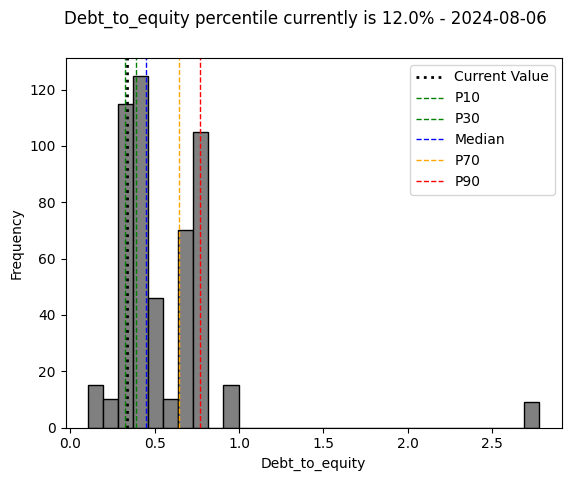

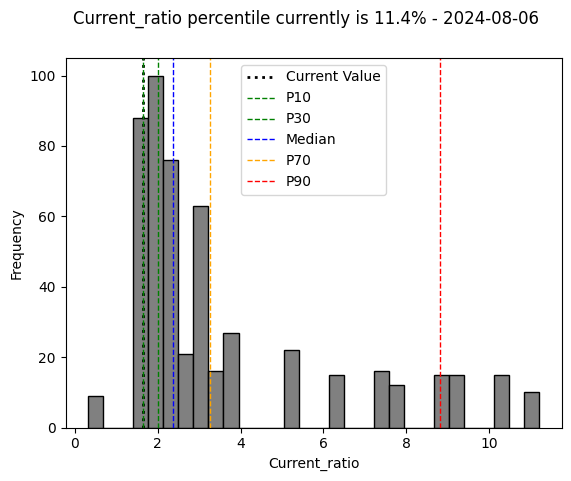

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.980790,0.127742,0.104311,-0.549958,-0.555372,-0.067852,-0.150240
roe,0.980790,1.000000,0.138980,0.129288,-0.536368,-0.577499,-0.171520,-0.140420
pe_ratio,0.127742,0.138980,1.000000,-0.010177,-0.179073,-0.204507,-0.133105,0.308938
pb_ratio,0.104311,0.129288,-0.010177,1.000000,0.314417,0.181280,0.089711,-0.286202
ps_ratio,-0.549958,-0.536368,-0.179073,0.314417,1.000000,0.954521,0.192249,-0.081445
ev_revenue,-0.555372,-0.577499,-0.204507,0.181280,0.954521,1.000000,0.429567,-0.165055
debt_to_equity,-0.067852,-0.171520,-0.133105,0.089711,0.192249,0.429567,1.000000,-0.484455
current_ratio,-0.150240,-0.140420,0.308938,-0.286202,-0.081445,-0.165055,-0.484455,1.000000


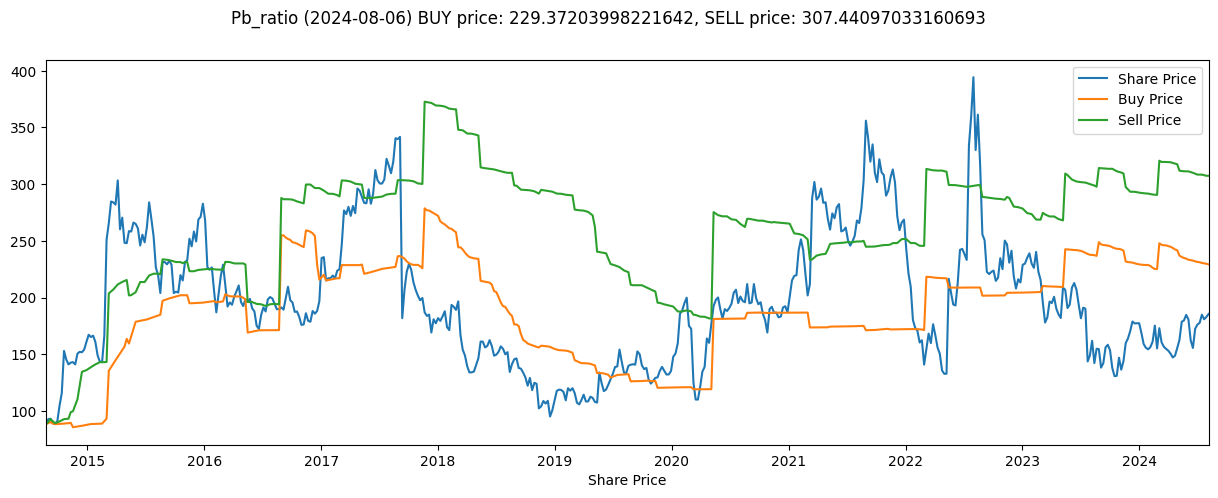

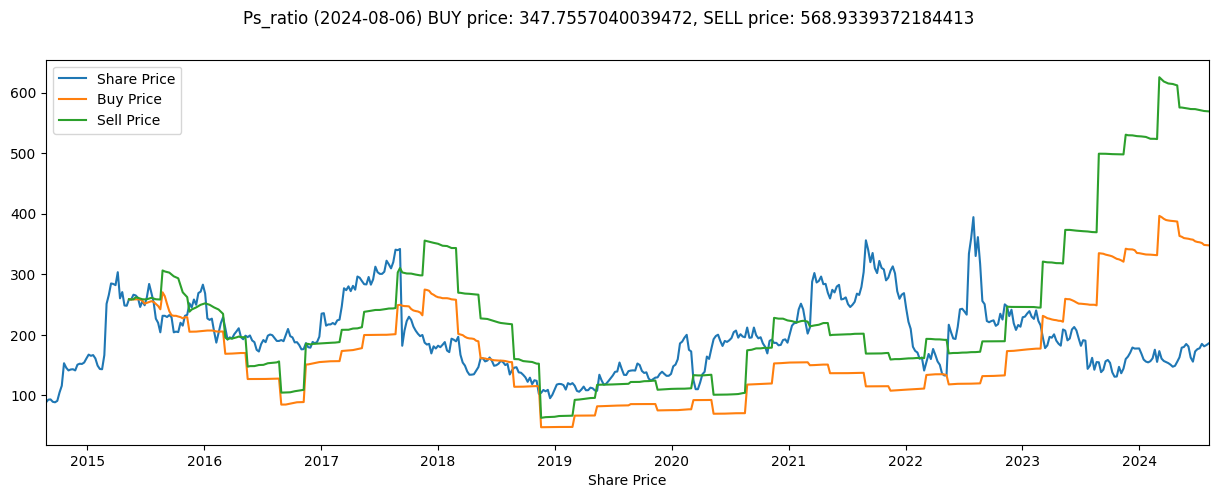

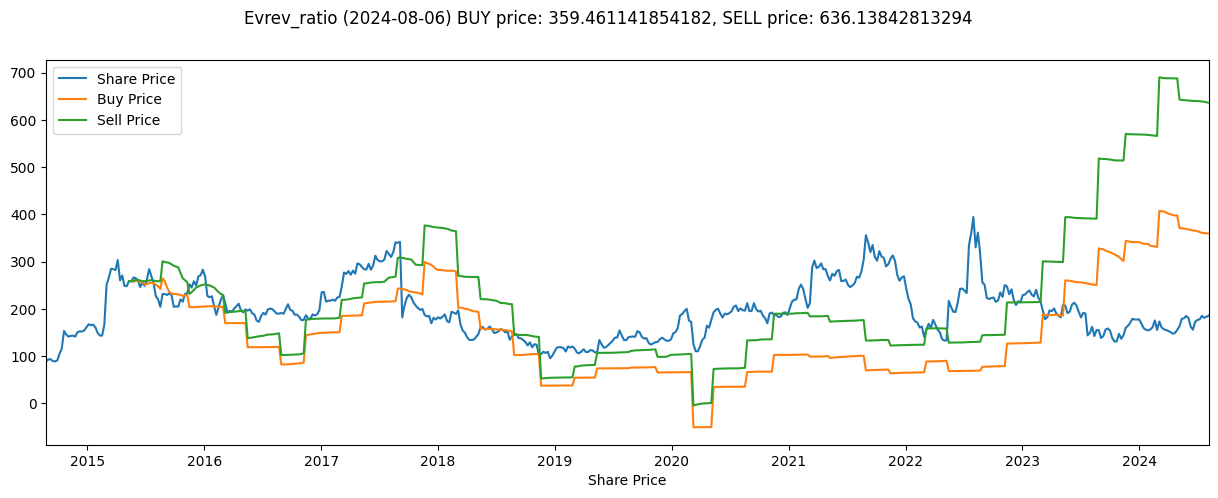

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)